In [5]:
from manim import *

config.media_width = "100%"
_RV = "-v WARNING -qm --progress_bar None --disable_caching Example"
_RI = "-v WARNING -s --progress_bar None --disable_caching Example"

Manim Community v0.17.2

In [6]:
from scipy import integrate
import numdifftools as nd

import matplotlib.pyplot as plt

In [3]:
#!pip install numdifftools

## Clase `CargaPuntual2D`

In [4]:
class CargaPuntual2D(VMobject):

    def __init__(self, pos=np.array([0, 0, 0]), q=1.6e-19, q_draw=1):
        
        super().__init__()
        
        self.pos = pos
        self.q = q
        self.q_draw = q_draw
        
        self.create()
        
        
    def create(self):
        
        #carga = Dot(color=RED if self.q_draw > 0 else BLUE).scale(2).move_to(self.pos)
        carga = Circle(radius=0.15, color=RED_B if self.q_draw > 0 else BLUE_B)\
                .set_fill(RED_E if self.q_draw > 0 else BLUE_E, 1).move_to(self.pos)
        
        self.add(carga)
        
        
    def campo(self, r, q):
        
        x, y, z = r
        
        k = 8.99e9
        
        return np.array([
            k * (x - self.pos[0]) * q / 
                    (((x - self.pos[0])**2 + (y - self.pos[1])**2 + (z - self.pos[2])**2)**(3/2)), # x coord
            k * (y - self.pos[1]) * q / 
                    (((x - self.pos[0])**2 + (y - self.pos[1])**2 + (z - self.pos[2])**2)**(3/2)), # y coord
            k * (z - self.pos[2]) * q / 
                    (((x - self.pos[0])**2 + (y - self.pos[1])**2 + (z - self.pos[2])**2)**(3/2))  # z coord
        ])
    
    
    def campo_draw(self, p):
        return self.campo(p, self.q_draw)
    
    
    def campo_real(self, p):
        return self.campo(p, self.q)
        

## Agregar traslación al dipolo, cálculo en la clase `DipoloElectrico2D`

In [5]:
class DipoloElectrico2D(VMobject):
    

    def __init__(self, angle, pos=np.array([0, 0, 0]), 
                 t_start=0, t_end=30, ele=140e-9, q=1.6e-19, m=1e-16, fields=[],
                 longitud_escala=[40e-9, 140e-9], fps=30):
        
        super().__init__()
        
        self.angle = angle  # con respecto al campo total
        self.pos = pos
        self.t_start = t_start
        self.t_end = t_end
        self.ele = ele
        self.q1 = q
        self.q2 = -q
        self.m = m                # masa del proton mas electron = 1.67271e-27
        self.fields = fields
        self.longitud_escala = longitud_escala
        self.fps = int(fps)
        
        self.dE = nd.Gradient(self.campo_en_punto) # gradiente o jacobiano, es lo mismo ya que es una función vectorial
        
        self.create()
        self.calculate_dynamics()
        
    def create(self):
        
        longiud2 = self.escalar([self.ele], self.longitud_escala, [0.15, 0.8])[0]
        stroke_w = self.escalar([self.ele], self.longitud_escala, [4, 9])[0]
        scaledot = self.escalar([self.ele], self.longitud_escala, [1, 3])[0]
        
        linea = Line(LEFT * longiud2, RIGHT * longiud2, stroke_width=stroke_w) # 0.15 - 0.8, 4 - 9
        
        polo_positivo = Dot(color=RED).scale(scaledot).move_to(linea.get_end())    # 1 - 3
        polo_negativo = Dot(color=BLUE).scale(scaledot).move_to(linea.get_start()) # 1 - 3
        
        linea.add(polo_positivo, polo_negativo)
        
        self.add(linea)
        
        self.move_to(self.pos)
        

    def calculate_dynamics(self):
        
        theta = self.angle  # angulo inicial
        omega = 0.0         # velocidad angular inicial
        
        # asumiendo que el centro de ele está en el origen
        r_pos = np.array([(self.ele/2)*np.cos(theta), (self.ele/2)*np.sin(theta), 0])    # carga positva
        r_neg = np.array([-(self.ele/2)*np.cos(theta), -(self.ele/2)*np.sin(theta), 0])  # carga negativa
        
        #l = r_neg - r_pos
        l = r_pos - r_neg
        p = l * self.q1
        
        I = self.momento_inercia_dos_masas(self.m, l)
        #I = self.momento_inercia_esfera_solida(self.m, l)
        
        E = self.campo_en_punto(self.pos)
        
        print("r_pos =", r_pos)
        print("r_neg =", r_neg)
        print("l =", l)
        print("p =", p)
        print("I =", I)
        print("E =", E)
        print("------------")
        print("iterations =", self.t_end * self.fps + 2)
        
        
        self.count_steps = 0
        self.solution = integrate.solve_ivp(self.angulo_dipolo, 
                                            [self.t_start, self.t_end], 
                                            [theta, omega],
                                            method='RK45', 
                                            t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2),
                                            args=(I, p)
                                           )
        print("self.count_steps =", self.count_steps)
        print("------------")
        # sumar el angulo del campo E (en la posicion del dipolo, sin traslacion, ésta no cambia)
        E_angle = np.arctan2(E[1], E[0])
        print("E_angle =", E_angle)
        #self.solution_and_E_angle = self.solution.y[0] + E_angle
        
        self.solution_F = integrate.solve_ivp(self.traslacion_dipolo, 
                                              [self.t_start, self.t_end], 
                                              [self.pos[0], self.pos[1], self.pos[2], 0, 0, 0],
                                              method='RK45', 
                                              t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2),
                                              args=(p,)
                                             )
        
    def angulo_dipolo(self, t, theta, I, p):
    
        #print("self.count_steps =", self.count_steps)
        self.count_steps = self.count_steps + 1
    
        # componentes
        x, v = theta    # x: theta, v: omega
        
        E = self.campo_en_punto(self.pos)  # debe cambiar cuando haya traslacion
        
        #print("E =", E)
        
        tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(x)
        
        #print("tau =", tau)
        
        a = -tau / I if I != 0 else 0  # tau es negativo por la regla de la mano derecha, va hacia adentro de la página

        return [v, a]  # velocidad (omega, primera derivada) y aceleración (alpha, segunda derivada)
    
    def traslacion_dipolo(self, t, r, p):
        
        # componentes
        x, y, z, vx, vy, vz = r
        
        dE_r = self.dE([x, y, z])
        
        theta = self.angle  # angulo inicial, actualizar con el calculado
        
        # asumiendo que el centro de ele está en el origen <- cambiar!
        #r_pos = np.array([(self.ele/2)*np.cos(theta) + x, (self.ele/2)*np.sin(theta) + y, 0])    # carga positva
        #r_neg = np.array([-(self.ele/2)*np.cos(theta) + x, -(self.ele/2)*np.sin(theta) + y, 0])  # carga negativa
        
        #l = r_neg - r_pos
        #l = r_pos - r_neg
        #p = self.p
        
        #print("dE_r =", dE_r)
        
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2]) #* 1e13
        ay = ( 1/self.m ) * (p[0] * dE_r[1][0] + p[1] * dE_r[1][1] + p[2] * dE_r[1][2]) #* 1e13
        az = ( 1/self.m ) * (p[0] * dE_r[2][0] + p[1] * dE_r[2][1] + p[2] * dE_r[2][2]) #* 1e13
        
        #print("[vx, vy, vz] = ", [vx, vy, vz])
        #print("ax =", ax)
        #self.p = l * self.q1
        
        return [vx, vy, vz, ax, ay, az]


    def momento_inercia_barra(self, m, l):

        #return np.array([m * l[0]**2, m * l[1]**2, m * l[2]**2]) / 12
        return m * np.linalg.norm(l)**2 / 12
    
        
    def momento_inercia_dos_masas(self, m, l): 
        # m es la masa total, entonces m1 = m2 = m/2
        # usa la masa reducida = m1m2/(m1+m2) = (m^2/4) / (m) = m/4
        
        return m * np.linalg.norm(l)**2 / 4
    
    
    def momento_inercia_esfera_solida(self, m, l):
        # aqui se considera el radio (no el diametro)
        
        return 2 * m * (np.linalg.norm(l)/2)**2 / 5
    
    
    def campo_en_punto(self, p):
        
        total_field = np.array([0., 0., 0.])
        for field in self.fields:
            total_field += field.campo_real(p)
        
        return total_field
    
    
    def escalar(self, values, actual_bounds, desired_bounds):
        return [
            desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0])
            / (actual_bounds[1] - actual_bounds[0]) 
            for x in values
        ]

In [8]:
fields = [
    CargaPuntual2D(q=15e-5)#500e2)#5e-7)
]

dipolo = DipoloElectrico2D(PI/3, pos=np.array([1, 1, 0]), t_end=30,
                           fps=30, m=1e-7,#m=1e-16,#m=1e-7,#m=1e-18,
                           fields=fields, ele=140e-9)

r_pos = [3.50000000e-08 6.06217783e-08 0.00000000e+00]
r_neg = [-3.50000000e-08 -6.06217783e-08  0.00000000e+00]
l = [7.00000000e-08 1.21243557e-07 0.00000000e+00]
p = [1.1200000e-26 1.9398969e-26 0.0000000e+00]
I = 4.900000000000001e-22
E = [476766.74721503 476766.74721503      0.        ]
------------
iterations = 902
self.count_steps = 1262
------------
E_angle = 0.7853981633974483
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.654306884060666e-13
ax = -1.6543068840605002

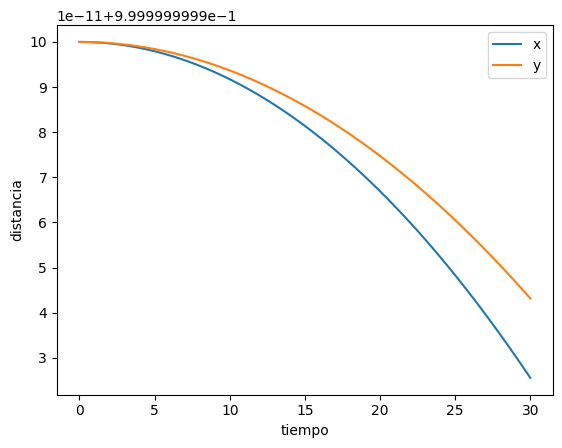

In [9]:
plt.plot(dipolo.solution_F.t, dipolo.solution_F.y[0], label="x")
plt.plot(dipolo.solution_F.t, dipolo.solution_F.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

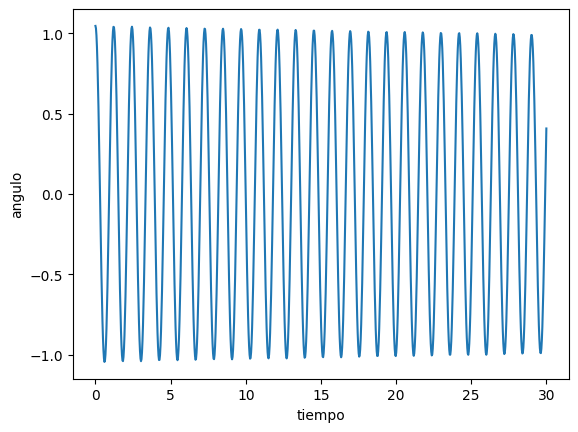

In [10]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [11]:
len(dipolo.solution.y[0])

902

In [12]:
dipolo.solution

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.330e-02 ...  2.997e+01  3.000e+01]
        y: [[ 1.047e+00  1.032e+00 ...  2.428e-01  4.083e-01]
            [ 0.000e+00 -8.862e-01 ...  5.119e+00  4.791e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1262
     njev: 0
      nlu: 0

In [13]:
# probar con que sacar la derivada el camo E

from scipy.misc import derivative    # el método de scipy es obsoleto y ellos mismos recomiendan 'numdifftools' 

fields = [
    CargaPuntual2D()
]

def e_field_real(p):
    total_field = np.array([0., 0., 0.])
    for field in fields:
        total_field += field.campo_real(p)
    print('total_field =', total_field)
    return total_field

r = [1, 1, 0]

derivative(lambda x:x**3, 2, dx=1e-6)

C:\Users\clauz\AppData\Local\Temp\ipykernel_37264\4243460408.py:18: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(lambda x:x**3, 2, dx=1e-6)


12.000000000789157

In [447]:
fields = [
    CargaPuntual2D()#q=5e-5)
]

def e_field_real(p):
    #print("p =", p)
    total_field = np.array([0., 0., 0.])
    for field in fields:
        total_field += field.campo_real(p)
    #print('total_field =', total_field)
    return total_field

r = [1, 1, 0]

dE = nd.Derivative(e_field_real)

dE(r)

array([-1.01710239e-09, -1.01710239e-09,  5.08551197e-10])

In [448]:
dE = nd.Gradient(e_field_real)

dE([1, 1, 0])

array([[-2.54275599e-10, -7.62826796e-10,  0.00000000e+00],
       [-7.62826796e-10, -2.54275599e-10,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.08551197e-10]])

In [449]:
dE = nd.Jacobian(e_field_real)

dE([1, 1, 0])

array([[-2.54275599e-10, -7.62826796e-10,  0.00000000e+00],
       [-7.62826796e-10, -2.54275599e-10,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.08551197e-10]])

In [450]:
dE_r = nd.Gradient(e_field_real)([1, 1, 0])

dE_r[1][0]

-7.628267955440492e-10

In [18]:
#for x in dipolo.solution_F.y[0]:
#    print(x)

In [460]:
# Corroborar el cálculo de la derivada que hace la librería numdifftools

k=8.99e9
A = fields[0].q
B = 0
a = 0
b = 0
c = 0

x, y, z = 1, 1, 0
x, y, z = 6e-3, 6e-3, 0

derivative_dEx_dx_110 = k*A*(a**2+a*(x-3*B)+b**2-2*b*y+3*B*x+c**2-2*c*z-2*x**2+y**2+z**2)\
                                                    /((x-a)**2+(y-b)**2+(z-c)**2)**(5/2)
derivative_dEx_dy_110 = -k*(3*A*(y-b)*(x-B))/((x-a)**2+(y-b)**2+(z-c)**2)**(5/2)
derivative_dEx_dz_110 = -k*(3*A*(z-c)*(x-B))/((x-a)**2+(y-b)**2+(z-c)**2)**(5/2)

print("derivative_dEx_dx_110 =", derivative_dEx_dx_110)
print("derivative_dEx_dy_110 =", derivative_dEx_dy_110)
print("derivative_dEx_dz_110 =", derivative_dEx_dz_110)

derivative_dEx_dx_110 = -0.0011772018449753819
derivative_dEx_dy_110 = -0.0035316055349261456
derivative_dEx_dz_110 = -0.0


In [461]:
# Corroborar el cálculo de la derivada que hace la librería numdifftools, expresion se E_0z

k=8.99e9
A = fields[0].q
B = 0
a = 0
b = 0
c = 0

x, y, z = 1, 1, 0
x, y, z = 6e-3, 6e-3, 0

derivative_dEz_dx_110 = -k*(3*A*(x-a)*(z-B))/((a-x)**2+(b-y)**2+(c-z)**2)**(5/2)
derivative_dEz_dy_110 = -k*(3*A*(y-b)*(z-B))/((a-x)**2+(b-y)**2+(c-z)**2)**(5/2)
derivative_dEz_dz_110 = k*A*(a**2-2*a*x+b**2-2*b*y-3*B*c+3*B*z+c**2+c*z+x**2+y**2-2*z**2)\
                                                    /((x-a)**2+(y-b)**2+(z-c)**2)**(5/2)

print("derivative_dEz_dx_110 =", derivative_dEz_dx_110)
print("derivative_dEz_dy_110 =", derivative_dEz_dy_110)
print("derivative_dEz_dz_110 =", derivative_dEz_dz_110)

derivative_dEz_dx_110 = -0.0
derivative_dEz_dy_110 = -0.0
derivative_dEz_dz_110 = 0.0023544036899507638


In [462]:
r = [1, 1, 0]
r = [6e-3, 6e-3, 0]

dE = nd.Gradient(e_field_real)

dE(r)

array([[-0.0011772 , -0.00353161,  0.        ],
       [-0.00353161, -0.0011772 ,  0.        ],
       [ 0.        ,  0.        ,  0.0023544 ]])

In [21]:
fields[0].q

1.6e-19

In [22]:
len(np.linspace(0, 30, 30 * 30 + 2))

902

#### Extracción del código de las ecuacioens diferenciales para preguntar en el foro del curso de métodos numéricos en Udemy

In [96]:
from scipy import integrate  # to calculate the partial derivatives
import numdifftools as nd    # to calculate the gradient


pos = np.array([0, 0, 0])    # point charge position (electric field generator)
Q = 15e-5                    # [Coulombs] = [C], charge of the point charge
k = 8.99e9                   # [N m^2 / C^2] = [(Kg m^3)/(s^4 A^2)], coulomb constant


def field_due_point_charge(r): #position where want the E field
    x, y, z = r
    
    return np.array([
        k * (x - pos[0]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2)), # x coord
        k * (y - pos[1]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2)), # y coord
        k * (z - pos[2]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2))  # z coord
    ])


def moment_inertia(m, l): # mass, diameter
    # I consider it as a sphere, but it can be a rod or whatever
    return 2 * m * (np.linalg.norm(l)/2)**2 / 5


def dipole_angle(t, theta, I, p):
    
    # components
    x, v = theta    # x: theta, v: omega
    E = field_due_point_charge(pos_dip) # should change when updating displacement (to do...)
    tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(x)
    a = -tau / I if I != 0 else 0  # tau is negative by the right hand rule, it goes into the page
    
    return [v, a]  # velocity (omega, first derivative) and acceleration (alpha, second derivative)


def dipole_displacement(t, r, p):
        
        # components
        x, y, z, vx, vy, vz = r
        dE_r = dE([x, y, z])
        
        ax = ( 1/m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        ay = ( 1/m ) * (p[0] * dE_r[1][0] + p[1] * dE_r[1][1] + p[2] * dE_r[1][2])
        az = ( 1/m ) * (p[0] * dE_r[2][0] + p[1] * dE_r[2][1] + p[2] * dE_r[2][2])
        
        return [vx, vy, vz, ax, ay, az]


# I'm thinking of a virus, that's why the mass, the diameter and the moment of inertia are chosen that way
    
pos_dip = np.array([1, 1, 0])  # dipole position
ele = 140e-9                   # [meters], distance between the two charges (virus diameter)
m = 1e-16                      # [Kg], dipole mass (virus mass), (works with m=1e-7)
q1 = 1.6e-19                   # [Coulombs], charge of each extreme of the dipole (to calculate dipole moment)
t_end = 30                     # [seconds], final time
t_start = 0                    # [seconds], initial time
fps = 30                       # frames per second, to later create an animation
theta = np.pi/3                # initial angle
omega = 0.0                    # initial angular velocity


# It works with this value, but I actually want the ones listed above
m = 1e-7



# assuming that the center of ele is at the origin
r_pos = np.array([(ele/2)*np.cos(theta), (ele/2)*np.sin(theta), 0])    # positive charge
r_neg = np.array([-(ele/2)*np.cos(theta), -(ele/2)*np.sin(theta), 0])  # negative charge

l = r_pos - r_neg              # vector of the distance of the two charges
p = l * q1                     # dipole moment

I = moment_inertia(m, l)       # moment of inertia

E = field_due_point_charge(pos_dip)  # [V/m], electric field due to a point charge, at position 'pos_dip'

dE = nd.Gradient(field_due_point_charge) # gradient or jacobian, it is the same since it is a vector function
                                         # necessary for displacement force

print("r_pos =", r_pos)
print("r_neg =", r_neg)
print("l =", l)
print("p =", p)
print("I =", I)
print("E =", E)
print("------------")
print("iterations =", t_end * fps + 2)


solution_A = integrate.solve_ivp(dipole_angle, 
                                  [t_start, t_end], 
                                  [theta, omega],
                                  method='RK45', 
                                  t_eval=np.linspace(t_start, t_end, t_end * fps + 2),
                                  args=(I, p)
                                  #rtol=1e-9, atol=1e-12
                                 )


# I also want to calculate the displacement, but here it does not calculate 
# any movement, it always stays in the same position
# with some numbers if it calculates displacement in x and y
solution_F = integrate.solve_ivp(dipole_displacement, 
                                  [t_start, t_end], 
                                  [pos_dip[0], pos_dip[1], pos_dip[2], 0, 0, 0],
                                  method='RK45', 
                                  t_eval=np.linspace(t_start, t_end, t_end * fps + 2),
                                  args=(p,)
                                 )




r_pos = [3.50000000e-08 6.06217783e-08 0.00000000e+00]
r_neg = [-3.50000000e-08 -6.06217783e-08  0.00000000e+00]
l = [7.00000000e-08 1.21243557e-07 0.00000000e+00]
p = [1.1200000e-26 1.9398969e-26 0.0000000e+00]
I = 1.9600000000000004e-22
E = [476766.74721503 476766.74721503      0.        ]
------------
iterations = 902


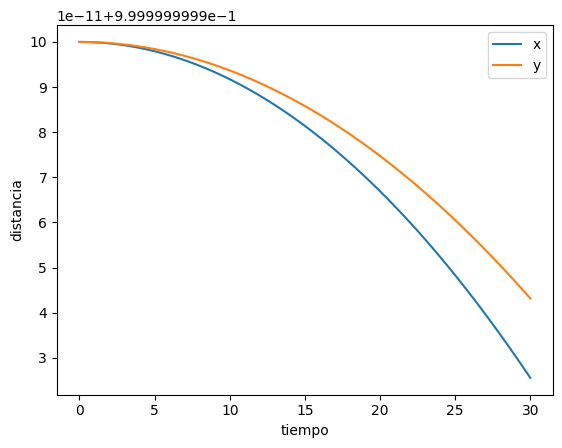

In [97]:
plt.plot(solution_F.t, solution_F.y[0], label="x")
plt.plot(solution_F.t, solution_F.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

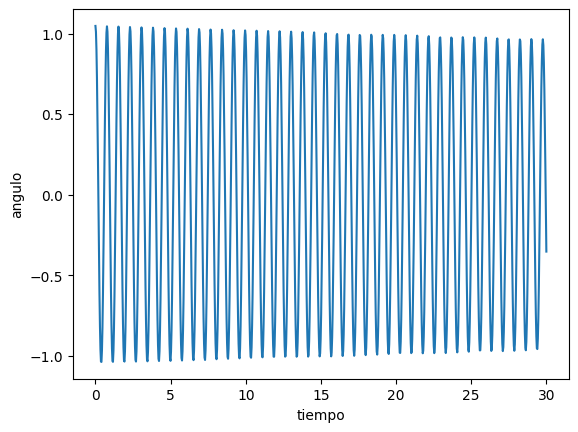

In [98]:
plt.plot(solution_A.t, solution_A.y[0])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [66]:
len(solution_F.y[0])

2

In [67]:
len(solution_A.y[0])

2481

In [68]:
solution_A.y[0]

array([1.04719755, 1.04719755, 1.04719755, ..., 0.54893354, 0.93811299,
       1.0045552 ])

In [41]:
np.linspace(t_start, t_end, t_end * fps + 2)

array([ 0.        ,  0.03329634,  0.06659267,  0.09988901,  0.13318535,
        0.16648169,  0.19977802,  0.23307436,  0.2663707 ,  0.29966704,
        0.33296337,  0.36625971,  0.39955605,  0.43285239,  0.46614872,
        0.49944506,  0.5327414 ,  0.56603774,  0.59933407,  0.63263041,
        0.66592675,  0.69922309,  0.73251942,  0.76581576,  0.7991121 ,
        0.83240844,  0.86570477,  0.89900111,  0.93229745,  0.96559378,
        0.99889012,  1.03218646,  1.0654828 ,  1.09877913,  1.13207547,
        1.16537181,  1.19866815,  1.23196448,  1.26526082,  1.29855716,
        1.3318535 ,  1.36514983,  1.39844617,  1.43174251,  1.46503885,
        1.49833518,  1.53163152,  1.56492786,  1.5982242 ,  1.63152053,
        1.66481687,  1.69811321,  1.73140954,  1.76470588,  1.79800222,
        1.83129856,  1.86459489,  1.89789123,  1.93118757,  1.96448391,
        1.99778024,  2.03107658,  2.06437292,  2.09766926,  2.13096559,
        2.16426193,  2.19755827,  2.23085461,  2.26415094,  2.29

#### Sugerencia del instructor del curso: no pedirle a `solve_ivp` tanto tiempo

In [140]:
from scipy import integrate  # to calculate the partial derivatives
import numdifftools as nd    # to calculate the gradient


pos = np.array([0, 0, 0])    # point charge position (electric field generator)
Q = 15e-5                    # [Coulombs] = [C], charge of the point charge
k = 8.99e9                   # [N m^2 / C^2] = [(Kg m^3)/(s^4 A^2)], coulomb constant


def field_due_point_charge(r): #position where want the E field
    x, y, z = r
    
    return np.array([
        k * (x - pos[0]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2)), # x coord
        k * (y - pos[1]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2)), # y coord
        k * (z - pos[2]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2))  # z coord
    ])


def moment_inertia(m, l): # mass, diameter
    # I consider it as a sphere, but it can be a rod or whatever
    return 2 * m * (np.linalg.norm(l)/2)**2 / 5


def dipole_angle(t, theta, I, p):
    #print(t)
    # components
    x, v = theta    # x: theta, v: omega
    E = field_due_point_charge(pos_dip) # should change when updating displacement (to do...)
    tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(x)
    a = -tau / I if I != 0 else 0  # tau is negative by the right hand rule, it goes into the page
    
    return [v, a]  # velocity (omega, first derivative) and acceleration (alpha, second derivative)


def dipole_displacement(t, r, p):
        
        # components
        x, y, z, vx, vy, vz = r
        dE_r = dE([x, y, z])
        
        ax = ( 1/m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        ay = ( 1/m ) * (p[0] * dE_r[1][0] + p[1] * dE_r[1][1] + p[2] * dE_r[1][2])
        az = ( 1/m ) * (p[0] * dE_r[2][0] + p[1] * dE_r[2][1] + p[2] * dE_r[2][2])
        
        return [vx, vy, vz, ax, ay, az]


# I'm thinking of a virus, that's why the mass, the diameter and the moment of inertia are chosen that way
    
pos_dip = np.array([1, 1, 0])  # dipole position
ele = 140e-9                   # [meters], distance between the two charges (virus diameter)
m = 1e-16                      # [Kg], dipole mass (virus mass), (works with m=1e-7)
q1 = 1.6e-19                   # [Coulombs], charge of each extreme of the dipole (to calculate dipole moment)
t_end = 0.0005                 # [seconds], final time <- funciona con 0.05, 0.005 pero con 0.0005 se ven las oscilaciones
t_start = 0                    # [seconds], initial time
fps = 30                       # frames per second, to later create an animation
theta = np.pi/3                # initial angle
omega = 0.0                    # initial angular velocity


# It works with this value, but I actually want the ones listed above
#m = 1e-7



# assuming that the center of ele is at the origin
r_pos = np.array([(ele/2)*np.cos(theta), (ele/2)*np.sin(theta), 0])    # positive charge
r_neg = np.array([-(ele/2)*np.cos(theta), -(ele/2)*np.sin(theta), 0])  # negative charge

l = r_pos - r_neg              # vector of the distance of the two charges
p = l * q1                     # dipole moment

I = moment_inertia(m, l)       # moment of inertia

E = field_due_point_charge(pos_dip)  # [V/m], electric field due to a point charge, at position 'pos_dip'

dE = nd.Gradient(field_due_point_charge) # gradient or jacobian, it is the same since it is a vector function
                                         # necessary for displacement force

print("r_pos =", r_pos)
print("r_neg =", r_neg)
print("l =", l)
print("p =", p)
print("I =", I)
print("E =", E)
print("------------")
print("iterations =", t_end * fps + 2)


solution_A = integrate.solve_ivp(dipole_angle, 
                                  [t_start, t_end], 
                                  [theta, omega],
                                  method='Radau',#'RK45', # cn el RK45 la gráfica de la oscilación se ve mas fea
                                  #t_eval=np.linspace(t_start, t_end, t_end * fps + 2), # si no lo indico me da 257 puntos
                                  t_eval=np.linspace(t_start, t_end, 902),  # pero quiero 902 puntos evaluados
                                  args=(I, p),
                                  vectorized=True
                                  #rtol=1e-9, atol=1e-12
                                 )


# I also want to calculate the displacement, but here it does not calculate 
# any movement, it always stays in the same position
# with some numbers if it calculates displacement in x and y
solution_F = integrate.solve_ivp(dipole_displacement, 
                                  [t_start, t_end], 
                                  [pos_dip[0], pos_dip[1], pos_dip[2], 0, 0, 0],
                                  method='Radau', 
                                  #t_eval=np.linspace(t_start, t_end, t_end * fps + 2),
                                  args=(p,)
                                 )




r_pos = [3.50000000e-08 6.06217783e-08 0.00000000e+00]
r_neg = [-3.50000000e-08 -6.06217783e-08  0.00000000e+00]
l = [7.00000000e-08 1.21243557e-07 0.00000000e+00]
p = [1.1200000e-26 1.9398969e-26 0.0000000e+00]
I = 1.9600000000000001e-31
E = [476766.74721503 476766.74721503      0.        ]
------------
iterations = 2.015


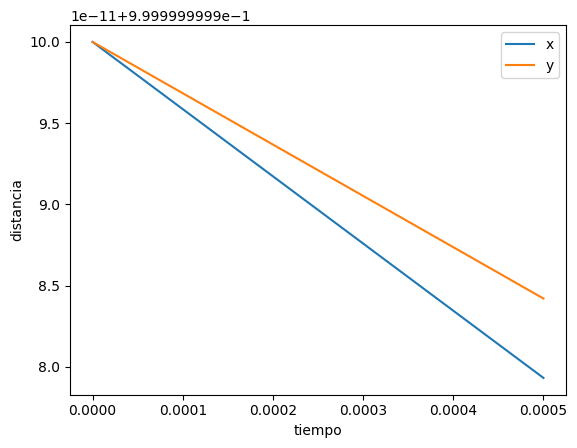

In [141]:
plt.plot(solution_F.t, solution_F.y[0], label="x")
plt.plot(solution_F.t, solution_F.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

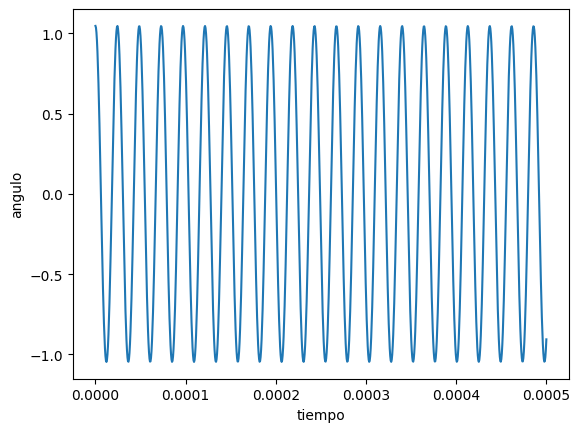

In [142]:
plt.plot(solution_A.t, solution_A.y[0])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [127]:
len(solution_A.y[0])

257

In [55]:
np.linspace(0., 0.05, 0.005 * 30 + 2)

TypeError: 'float' object cannot be interpreted as an integer

In [119]:
0.0005 * 30

0.015

#### Con una carga puntual que es un protón y a una micra de distancia en ambos ejes (números como en el cuaderno)

In [189]:
from scipy import integrate  # to calculate the partial derivatives
import numdifftools as nd    # to calculate the gradient


pos = np.array([0, 0, 0])    # point charge position (electric field generator)
Q = 1.6e-19                  # [Coulombs] = [C], charge of the point charge (a proton)
k = 8.99e9                   # [N m^2 / C^2] = [(Kg m^3)/(s^4 A^2)], coulomb constant


def field_due_point_charge(r): #position where want the E field
    x, y, z = r
    
    return np.array([
        k * (x - pos[0]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2)), # x coord
        k * (y - pos[1]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2)), # y coord
        k * (z - pos[2]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2))  # z coord
    ])


def moment_inertia(m, l): # mass, diameter
    # I consider it as a sphere, but it can be a rod or whatever
    return 2 * m * (np.linalg.norm(l)/2)**2 / 5


def dipole_angle(t, theta, I, p):
    
    # components
    x, v = theta    # x: theta, v: omega
    E = field_due_point_charge(pos_dip) # should change when updating displacement (to do...)
    tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(x)
    a = -tau / I if I != 0 else 0  # tau is negative by the right hand rule, it goes into the page
    
    return [v, a]  # velocity (omega, first derivative) and acceleration (alpha, second derivative)


def dipole_displacement(t, r, p):
        
        # components
        x, y, z, vx, vy, vz = r
        dE_r = dE([x, y, z])
        
        ax = ( 1/m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        ay = ( 1/m ) * (p[0] * dE_r[1][0] + p[1] * dE_r[1][1] + p[2] * dE_r[1][2])
        az = ( 1/m ) * (p[0] * dE_r[2][0] + p[1] * dE_r[2][1] + p[2] * dE_r[2][2])
        
        return [vx, vy, vz, ax, ay, az]


# I'm thinking of a virus, that's why the mass, the diameter and the moment of inertia are chosen that way
    
pos_dip = np.array([1e-6, 1e-6, 0])  # dipole position (a una micra en 'x' y en 'y')
ele = 140e-9                   # [meters], distance between the two charges (virus diameter)
m = 1e-16                      # [Kg], dipole mass (virus mass), (works with m=1e-7)
q1 = 1.6e-19                   # [Coulombs], charge of each extreme of the dipole (to calculate dipole moment)
t_end = 1                      # [seconds], final time <- funciona hasta con 10 segundos (probado hasta ahi)
t_start = 0                    # [seconds], initial time
fps = 30                       # frames per second, to later create an animation
theta = np.pi/3                # initial angle
omega = 0.0                    # initial angular velocity


# It works with this value, but I actually want the ones listed above
#m = 1e-7



# assuming that the center of ele is at the origin
r_pos = np.array([(ele/2)*np.cos(theta), (ele/2)*np.sin(theta), 0])    # positive charge
r_neg = np.array([-(ele/2)*np.cos(theta), -(ele/2)*np.sin(theta), 0])  # negative charge

l = r_pos - r_neg              # vector of the distance of the two charges
p = l * q1                     # dipole moment

I = moment_inertia(m, l)       # moment of inertia

E = field_due_point_charge(pos_dip)  # [V/m], electric field due to a point charge, at position 'pos_dip'

dE = nd.Gradient(field_due_point_charge) # gradient or jacobian, it is the same since it is a vector function
                                         # necessary for displacement force

# calculos para ver como son los numeros y sus ordenes de magnitud (la menos al inicio del desma)

tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
dE_r = dE(pos_dip)
ax = ( 1/m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        
print("r_pos =", r_pos)
print("r_neg =", r_neg)
print("l =", l)
print("p =", p)
print("I =", I)
print("E =", E)
print('tau =', tau)
print("alpha =", tau / I)
print("a_x =", ax)
print("------------")
print("iterations =", t_end * fps + 2)
print("[theta, omega] = ", [theta, omega])


solution_A = integrate.solve_ivp(dipole_angle, 
                                  [t_start, t_end], 
                                  [theta, omega],
                                  method='Radau',#'RK45', # cn el RK45 la gráfica de la oscilación se ve mas fea
                                  #t_eval=np.linspace(t_start, t_end, t_end * fps + 2), # si no lo indico me da 257 puntos
                                  t_eval=np.linspace(t_start, t_end, 902),  # pero quiero 902 puntos evaluados
                                  args=(I, p),
                                  vectorized=True
                                  #rtol=1e-9, atol=1e-12
                                 )


# I also want to calculate the displacement, but here it does not calculate 
# any movement, it always stays in the same position
# with some numbers if it calculates displacement in x and y
solution_F = integrate.solve_ivp(dipole_displacement, 
                                  [t_start, t_end], 
                                  [pos_dip[0], pos_dip[1], pos_dip[2], 0, 0, 0],
                                  method='Radau', 
                                  #t_eval=np.linspace(t_start, t_end, t_end * fps + 2),
                                  args=(p,)
                                 )




r_pos = [3.50000000e-08 6.06217783e-08 0.00000000e+00]
r_neg = [-3.50000000e-08 -6.06217783e-08  0.00000000e+00]
l = [7.00000000e-08 1.21243557e-07 0.00000000e+00]
p = [1.1200000e-26 1.9398969e-26 0.0000000e+00]
I = 1.9600000000000001e-31
E = [508.55119703 508.55119703   0.        ]
tau = 1.395173853699961e-23
alpha = 71182339.4744878
a_x = 1.2802098316462712e-28
------------
iterations = 32
[theta, omega] =  [1.0471975511965976, 0.0]


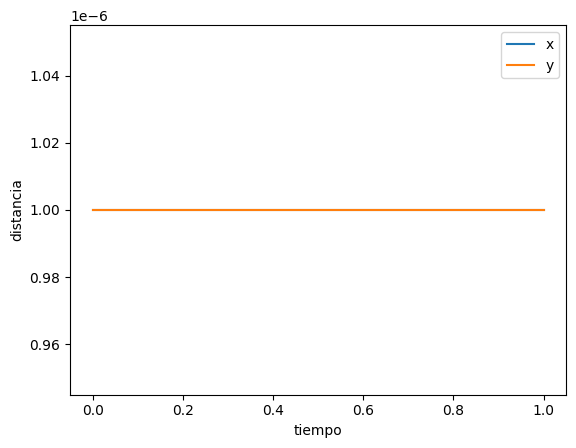

In [190]:
plt.plot(solution_F.t, solution_F.y[0], label="x")
plt.plot(solution_F.t, solution_F.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

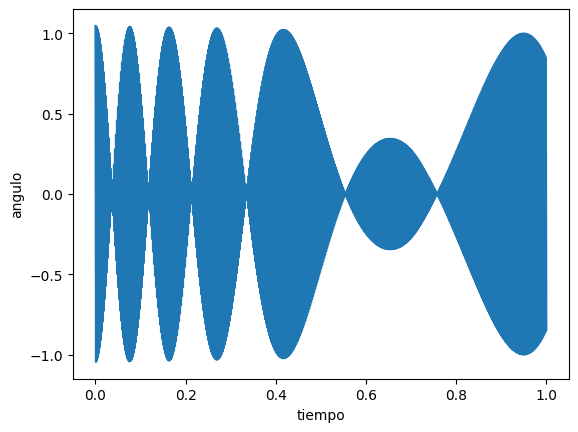

In [191]:
plt.plot(solution_A.t, solution_A.y[0])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [192]:
len(solution_F.y[0])

8

In [193]:
len(solution_A.y[0])

902

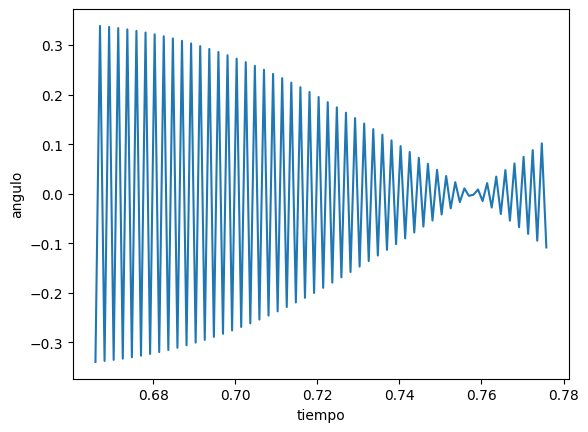

In [194]:
plt.plot(solution_A.t[600:700], solution_A.y[0][600:700])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

#### Con el dipolo a 100 nm de distancia

In [195]:
from scipy import integrate  # to calculate the partial derivatives
import numdifftools as nd    # to calculate the gradient


pos = np.array([0, 0, 0])    # point charge position (electric field generator)
Q = 1.6e-19                  # [Coulombs] = [C], charge of the point charge (a proton)
k = 8.99e9                   # [N m^2 / C^2] = [(Kg m^3)/(s^4 A^2)], coulomb constant


def field_due_point_charge(r): #position where want the E field
    x, y, z = r
    
    return np.array([
        k * (x - pos[0]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2)), # x coord
        k * (y - pos[1]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2)), # y coord
        k * (z - pos[2]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2))  # z coord
    ])


def moment_inertia(m, l): # mass, diameter
    # I consider it as a sphere, but it can be a rod or whatever
    return 2 * m * (np.linalg.norm(l)/2)**2 / 5


def dipole_angle(t, theta, I, p):
    
    # components
    x, v = theta    # x: theta, v: omega
    E = field_due_point_charge(pos_dip) # should change when updating displacement (to do...)
    tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(x)
    a = -tau / I if I != 0 else 0  # tau is negative by the right hand rule, it goes into the page
    
    return [v, a]  # velocity (omega, first derivative) and acceleration (alpha, second derivative)


def dipole_displacement(t, r, p):
        
        # components
        x, y, z, vx, vy, vz = r
        dE_r = dE([x, y, z])
        
        ax = ( 1/m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        ay = ( 1/m ) * (p[0] * dE_r[1][0] + p[1] * dE_r[1][1] + p[2] * dE_r[1][2])
        az = ( 1/m ) * (p[0] * dE_r[2][0] + p[1] * dE_r[2][1] + p[2] * dE_r[2][2])
        
        return [vx, vy, vz, ax, ay, az]


# I'm thinking of a virus, that's why the mass, the diameter and the moment of inertia are chosen that way
    
pos_dip = np.array([100e-9, 100e-9, 0])  # dipole position (a una micra en 'x' y en 'y')
ele = 140e-9                   # [meters], distance between the two charges (virus diameter)
m = 1e-16                      # [Kg], dipole mass (virus mass), (works with m=1e-7)
q1 = 1.6e-19                   # [Coulombs], charge of each extreme of the dipole (to calculate dipole moment)
t_end = 1                      # [seconds], final time <- funciona hasta con 10 segundos (probado hasta ahi)
t_start = 0                    # [seconds], initial time
fps = 30                       # frames per second, to later create an animation
theta = np.pi/3                # initial angle
omega = 0.0                    # initial angular velocity


# It works with this value, but I actually want the ones listed above
#m = 1e-7



# assuming that the center of ele is at the origin
r_pos = np.array([(ele/2)*np.cos(theta), (ele/2)*np.sin(theta), 0])    # positive charge
r_neg = np.array([-(ele/2)*np.cos(theta), -(ele/2)*np.sin(theta), 0])  # negative charge

l = r_pos - r_neg              # vector of the distance of the two charges
p = l * q1                     # dipole moment

I = moment_inertia(m, l)       # moment of inertia

E = field_due_point_charge(pos_dip)  # [V/m], electric field due to a point charge, at position 'pos_dip'

dE = nd.Gradient(field_due_point_charge) # gradient or jacobian, it is the same since it is a vector function
                                         # necessary for displacement force

# calculos para ver como son los numeros y sus ordenes de magnitud (la menos al inicio del desma)

tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
dE_r = dE(pos_dip)
ax = ( 1/m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        
print("r_pos =", r_pos)
print("r_neg =", r_neg)
print("l =", l)
print("p =", p)
print("I =", I)
print("E =", E)
print('tau =', tau)
print("alpha =", tau / I)
print("a_x =", ax)
print("------------")
print("iterations =", t_end * fps + 2)
print("[theta, omega] = ", [theta, omega])


solution_A = integrate.solve_ivp(dipole_angle, 
                                  [t_start, t_end], 
                                  [theta, omega],
                                  method='Radau',#'RK45', # cn el RK45 la gráfica de la oscilación se ve mas fea
                                  #t_eval=np.linspace(t_start, t_end, t_end * fps + 2), # si no lo indico me da 257 puntos
                                  t_eval=np.linspace(t_start, t_end, 902),  # pero quiero 902 puntos evaluados
                                  args=(I, p),
                                  vectorized=True
                                  #rtol=1e-9, atol=1e-12
                                 )


# I also want to calculate the displacement, but here it does not calculate 
# any movement, it always stays in the same position
# with some numbers if it calculates displacement in x and y
solution_F = integrate.solve_ivp(dipole_displacement, 
                                  [t_start, t_end], 
                                  [pos_dip[0], pos_dip[1], pos_dip[2], 0, 0, 0],
                                  method='Radau', 
                                  #t_eval=np.linspace(t_start, t_end, t_end * fps + 2),
                                  args=(p,)
                                 )




r_pos = [3.50000000e-08 6.06217783e-08 0.00000000e+00]
r_neg = [-3.50000000e-08 -6.06217783e-08  0.00000000e+00]
l = [7.00000000e-08 1.21243557e-07 0.00000000e+00]
p = [1.1200000e-26 1.9398969e-26 0.0000000e+00]
I = 1.9600000000000001e-31
E = [50855.11970294 50855.11970294     0.        ]
tau = 1.3951738536999611e-21
alpha = 7118233947.448781
a_x = 1.2807138165267418e-30
------------
iterations = 32
[theta, omega] =  [1.0471975511965976, 0.0]


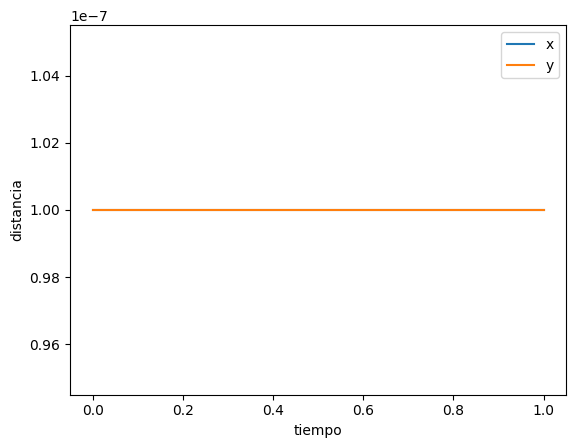

In [196]:
plt.plot(solution_F.t, solution_F.y[0], label="x")
plt.plot(solution_F.t, solution_F.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

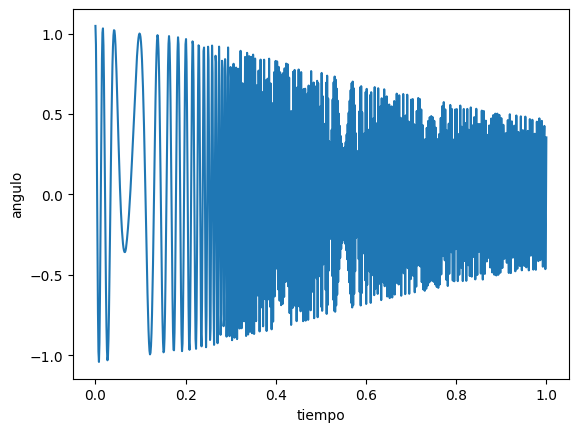

In [197]:
plt.plot(solution_A.t, solution_A.y[0])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [344]:
from scipy import integrate  # to calculate the partial derivatives
import numdifftools as nd    # to calculate the gradient


pos = np.array([0, 0, 0])    # point charge position (electric field generator)
Q = 1.6e-19                  # [Coulombs] = [C], charge of the point charge (a proton)
k = 8.99e9                   # [N m^2 / C^2] = [(Kg m^3)/(s^4 A^2)], coulomb constant


def field_due_point_charge(r): #position where want the E field
    x, y, z = r
    
    return np.array([
        k * (x - pos[0]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2)), # x coord
        k * (y - pos[1]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2)), # y coord
        k * (z - pos[2]) * Q / 
                (((x - pos[0])**2 + (y - pos[1])**2 + (z - pos[2])**2)**(3/2))  # z coord
    ])


def moment_inertia(m, l): # mass, diameter
    # I consider it as a sphere, but it can be a rod or whatever
    return 2 * m * (np.linalg.norm(l)/2)**2 / 5


def dipole_angle(t, theta, I, p):
    
    # components
    x, v = theta    # x: theta, v: omega
    E = field_due_point_charge(pos_dip) # should change when updating displacement (to do...)
    tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(x)
    a = -tau / I if I != 0 else 0  # tau is negative by the right hand rule, it goes into the page
    
    return [v, a]  # velocity (omega, first derivative) and acceleration (alpha, second derivative)


def dipole_displacement(t, r, p):
        
        # components
        x, y, z, vx, vy, vz = r
        dE_r = dE([x, y, z])
        
        ax = ( 1/m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        ay = ( 1/m ) * (p[0] * dE_r[1][0] + p[1] * dE_r[1][1] + p[2] * dE_r[1][2])
        az = ( 1/m ) * (p[0] * dE_r[2][0] + p[1] * dE_r[2][1] + p[2] * dE_r[2][2])
        
        return [vx, vy, vz, ax, ay, az]


# I'm thinking of a virus, that's why the mass, the diameter and the moment of inertia are chosen that way
    
pos_dip = np.array([6e-3, 6e-3, 0])  # dipole position (a una micra en 'x' y en 'y')
ele = 140e-9                   # [meters], distance between the two charges (virus diameter)
m = 1e-16                      # [Kg], dipole mass (virus mass), (works with m=1e-7)
q1 = 1.6e-19                   # [Coulombs], charge of each extreme of the dipole (to calculate dipole moment)
t_end = 30                     # [seconds], final time <- funciona hasta con 300 segundos (probado hasta ahi)
t_start = 0                    # [seconds], initial time
fps = 30                       # frames per second, to later create an animation
theta = np.pi/3                # initial angle
omega = 0.0                    # initial angular velocity


# It works with this value, but I actually want the ones listed above
#m = 1e-7



# assuming that the center of ele is at the origin
r_pos = np.array([(ele/2)*np.cos(theta), (ele/2)*np.sin(theta), 0])    # positive charge
r_neg = np.array([-(ele/2)*np.cos(theta), -(ele/2)*np.sin(theta), 0])  # negative charge

l = r_pos - r_neg              # vector of the distance of the two charges
p = l * q1                     # dipole moment

I = moment_inertia(m, l)       # moment of inertia

E = field_due_point_charge(pos_dip)  # [V/m], electric field due to a point charge, at position 'pos_dip'

dE = nd.Gradient(field_due_point_charge) # gradient or jacobian, it is the same since it is a vector function
                                         # necessary for displacement force

# calculos para ver como son los numeros y sus ordenes de magnitud (la menos al inicio del desma)

tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
dE_r = dE(pos_dip)
ax = ( 1/m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        
print("r_pos =", r_pos)
print("r_neg =", r_neg)
print("l =", l)
print("p =", p)
print("I =", I)
print("E =", E)
print('tau =', tau)
print("alpha =", tau / I)
print("a_x =", ax)
print("------------")
print("iterations =", t_end * fps + 2)
print("[theta, omega] = ", [theta, omega])


solution_A = integrate.solve_ivp(dipole_angle, 
                                  [t_start, t_end], 
                                  [theta, omega],
                                  method='Radau',#'RK45', # con el RK45 la gráfica de la oscilación se ve mas fea
                                  t_eval=np.linspace(t_start, t_end, t_end * fps + 2), # si no lo indico me da 257 puntos
                                  #t_eval=np.linspace(t_start, t_end, 902),  # pero quiero 902 puntos evaluados
                                  args=(I, p),
                                  vectorized=True
                                  #rtol=1e-9, atol=1e-12
                                 )


# I also want to calculate the displacement, but here it does not calculate 
# any movement, it always stays in the same position
# with some numbers if it calculates displacement in x and y
solution_F = integrate.solve_ivp(dipole_displacement, 
                                  [t_start, t_end], 
                                  [pos_dip[0], pos_dip[1], pos_dip[2], 0, 0, 0],
                                  method='Radau', 
                                  t_eval=np.linspace(t_start, t_end, t_end * fps + 2),
                                  args=(p,)
                                 )




r_pos = [3.50000000e-08 6.06217783e-08 0.00000000e+00]
r_neg = [-3.50000000e-08 -6.06217783e-08  0.00000000e+00]
l = [7.00000000e-08 1.21243557e-07 0.00000000e+00]
p = [1.1200000e-26 1.9398969e-26 0.0000000e+00]
I = 1.9600000000000001e-31
E = [1.41264221e-05 1.41264221e-05 0.00000000e+00]
tau = 3.8754829269443356e-31
alpha = 1.9772872076246608
a_x = -8.169416711861027e-13
------------
iterations = 902
[theta, omega] =  [1.0471975511965976, 0.0]


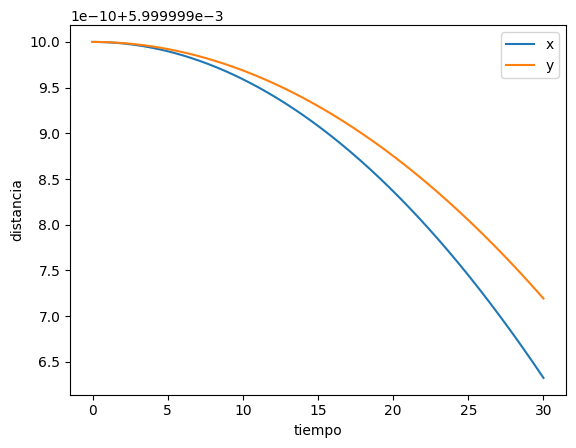

In [345]:
plt.plot(solution_F.t, solution_F.y[0], label="x")
plt.plot(solution_F.t, solution_F.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

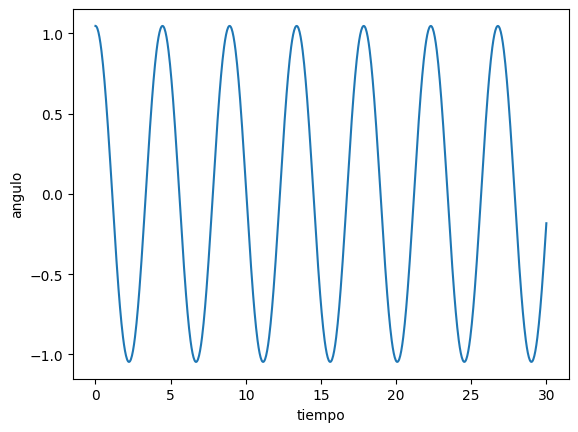

In [346]:
plt.plot(solution_A.t, solution_A.y[0])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [294]:
len(solution_F.y[0])

9002

In [295]:
for i in solution_F.y[0]:
    print(f"{i:.50f}")
    #print(i)

0.00600000000000000012490009027033011079765856266022
0.00599999999999954649471112233527492207940667867661
0.00599999999999818473678248054170580871868878602982
0.00599999999999591658583764086642986512742936611176
0.00599999999999274030715312733263999689370393753052
0.00599999999998865590072893994033620401751250028610
0.00599999999998366510128855466632558091077953577042
0.00599999999997776617410849553380103316158056259155
0.00599999999997095998655050053116610797587782144547
0.00599999999996324567125283167001725814770907163620
0.00599999999995462409557722693875803088303655385971
0.00599999999994509525952368633738842618186026811600
0.00599999999993465916309220986590844404418021440506
0.00599999999992331493892105953591453726403415203094
0.00599999999991106345437197333581025304738432168961
0.00599999999989790470944495126559559139423072338104
0.00599999999988383870413999332527055230457335710526
0.00599999999986886457109536152643158857244998216629
0.00599999999985298317767279385748224740382283

## Animación con traslación (los valores se ajustan para que se aprecien)

In [7]:
class CargaPuntual2D(VMobject):

    def __init__(self, pos=np.array([0, 0, 0]), q=1.6e-19, q_draw=1):
        
        super().__init__()
        
        self.pos = pos
        self.q = q
        self.q_draw = q_draw
        self.k = 8.99e9
        
        self.create()
        
        
    def create(self):
        
        #carga = Dot(color=RED if self.q_draw > 0 else BLUE).scale(2).move_to(self.pos)
        carga = Circle(radius=0.15, color=RED_B if self.q_draw > 0 else BLUE_B)\
                .set_fill(RED_E if self.q_draw > 0 else BLUE_E, 1).move_to(self.pos)
        
        self.add(carga)
        
        
    def campo(self, r, q, k):
        
        x, y, z = r
        #print('r =', x, y, z)
        
        denominador = (((x - self.pos[0])**2 + (y - self.pos[1])**2 + (z - self.pos[2])**2)**(3/2))
        
        return np.array([
            k * (x - self.pos[0]) * q / denominador if denominador != 0 else 0, # x coord
            k * (y - self.pos[1]) * q / denominador if denominador != 0 else 0, # y coord
            k * (z - self.pos[2]) * q / denominador if denominador != 0 else 0  # z coord
        ])
    
    
    def campo_draw(self, r):
        return self.campo(r, self.q_draw, 1)
    
    
    def campo_real(self, r):
        return self.campo(r, self.q, self.k)
        

In [15]:
class DipoloElectrico2D(VMobject):
    

    def __init__(self, angle, pos=np.array([6e-3, 6e-3, 0]), 
                 t_start=0, t_end=30, ele=140e-9, q=1.6e-19, m=1e-16, fields=[], 
                 pos_draw=np.array([0, 0, 0]),
                 longitud_escala=[40e-9, 140e-9], fps=30):
        
        super().__init__()
        
        self.angle = angle  # con respecto al campo total
        self.pos = pos
        self.t_start = t_start
        self.t_end = t_end
        self.ele = ele
        self.q1 = q
        self.q2 = -q
        self.m = m                # masa del proton mas electron = 1.67271e-27
        self.fields = fields
        self.pos_draw = pos_draw
        self.longitud_escala = longitud_escala
        self.fps = int(fps)
        
        self.dE = nd.Jacobian(self.campo_en_punto) # gradiente o jacobiano, es lo mismo ya que es una función vectorial
        
        self.create()
        self.calculate_dynamics()
        
    def create(self):
        
        longiud2 = self.escalar([self.ele], self.longitud_escala, [0.15, 0.8])[0]
        stroke_w = self.escalar([self.ele], self.longitud_escala, [4, 9])[0]
        scaledot = self.escalar([self.ele], self.longitud_escala, [1, 3])[0]
        
        linea = Line(LEFT * longiud2, RIGHT * longiud2, stroke_width=stroke_w) # 0.15 - 0.8, 4 - 9
        
        polo_positivo = Dot(color=RED).scale(scaledot).move_to(linea.get_end())    # 1 - 3
        polo_negativo = Dot(color=BLUE).scale(scaledot).move_to(linea.get_start()) # 1 - 3
        
        linea.add(polo_positivo, polo_negativo)
        
        self.add(linea)
        
        self.move_to(self.pos_draw)
        

    def calculate_dynamics(self):
        
        theta = self.angle  # angulo inicial
        omega = 0.0         # velocidad angular inicial
        
        # asumiendo que el centro de ele está en el origen
        r_pos = np.array([(self.ele/2)*np.cos(theta), (self.ele/2)*np.sin(theta), 0])    # carga positva
        r_neg = np.array([-(self.ele/2)*np.cos(theta), -(self.ele/2)*np.sin(theta), 0])  # carga negativa
        
        #l = r_neg - r_pos
        l = r_pos - r_neg
        p = l * self.q1
        
        #I = self.momento_inercia_dos_masas(self.m, l)
        I = self.momento_inercia_esfera_solida(self.m, l)
        
        E = self.campo_en_punto(self.pos)

        # calculos para ver como son los numeros y sus ordenes de magnitud (la menos al inicio del desma)

        tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
        dE_r = self.dE(self.pos)
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        
        print("r_pos =", r_pos)
        print("r_neg =", r_neg)
        print("l =", l)
        print("p =", p)
        print("I =", I)
        print("E =", E)
        print('tau =', tau)
        print("dE_r =", dE_r)
        print("alpha =", tau / I)
        print("a_x =", ax)
        print("------------")
        print("iterations =", self.t_end * self.fps + 2)
        print("[theta, omega] = ", [theta, omega])

        
        
        self.count_steps = 0
        self.solution_A = integrate.solve_ivp(self.angulo_dipolo, 
                                            [self.t_start, self.t_end], 
                                            [theta, omega],
                                            method='Radau',#'RK45'
                                            t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2),
                                            args=(I, p),
                                            vectorized=True
                                           )
        
        print("self.count_steps =", self.count_steps)
        print("------------")
        # sumar el angulo del campo E (en la posicion del dipolo, sin traslacion, ésta no cambia)
        E_angle = np.arctan2(E[1], E[0])
        print("E_angle =", E_angle)
        self.solution_and_E_angle = self.solution_A.y[0] + E_angle
        
        self.solution_F = integrate.solve_ivp(self.traslacion_dipolo, 
                                              [self.t_start, self.t_end], 
                                              [self.pos[0], self.pos[1], self.pos[2], 0, 0, 0],
                                              method='RK45',#'Radau',#'RK45'
                                              t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2),
                                              args=(p,)
                                             )
        
    def angulo_dipolo(self, t, theta, I, p):
    
        #print("self.count_steps =", self.count_steps)
        self.count_steps = self.count_steps + 1
    
        # componentes
        x, v = theta    # x: theta, v: omega
        
        E = self.campo_en_punto(self.pos)  # debe cambiar cuando haya traslacion
        
        tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(x)
        
        a = -tau / I if I != 0 else 0  # tau es negativa por la regla de la mano derecha, va hacia adentro de la página

        return [v, a]  # velocidad (omega, primera derivada) y aceleración (alpha, segunda derivada)
    
    
    def traslacion_dipolo(self, t, r, p):
        
        # componentes
        x, y, z, vx, vy, vz = r
        
        dE_r = self.dE([x, y, z])
        
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        ay = ( 1/self.m ) * (p[0] * dE_r[1][0] + p[1] * dE_r[1][1] + p[2] * dE_r[1][2])
        az = ( 1/self.m ) * (p[0] * dE_r[2][0] + p[1] * dE_r[2][1] + p[2] * dE_r[2][2])
        
        return [vx, vy, vz, ax, ay, az]


    def momento_inercia_barra(self, m, l):

        #return np.array([m * l[0]**2, m * l[1]**2, m * l[2]**2]) / 12
        return m * np.linalg.norm(l)**2 / 12
    
        
    def momento_inercia_dos_masas(self, m, l): 
        # m es la masa total, entonces m1 = m2 = m/2
        # usa la masa reducida = m1m2/(m1+m2) = (m^2/4) / (m) = m/4
        
        return m * np.linalg.norm(l)**2 / 4
    
    
    def momento_inercia_esfera_solida(self, m, l):
        # aqui se considera el radio (no el diametro)
        
        return 2 * m * (np.linalg.norm(l)/2)**2 / 5
    
    
    def campo_en_punto(self, r):
        
        total_field = np.array([0., 0., 0.])
        for field in self.fields:
            total_field += field.campo_real(r)
        
        return total_field
    
    
    def escalar(self, values, actual_bounds, desired_bounds):
        return [
            desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0])
            / (actual_bounds[1] - actual_bounds[0]) 
            for x in values
        ]

In [21]:
TOTAL_TIME = 30


class Example(Scene):

    def construct(self):
        
        fields = [
            CargaPuntual2D()
        ]
        
        for field in fields:
            self.add(field)
            field.set_z_index(10)
        
        def func_e_field(p):
            total_field = np.array([0., 0., 0.])
            for field in fields:
                total_field += field.campo_draw(p)
            return total_field
        
        vector_field = ArrowVectorField(func_e_field)
        vector_field._alpha = 1
        
        def show_field(mob, dt):
            # valor de alpha que quiero quitar en 3 segundos, el dt se usa para que el calculo considere fps y TOTAL_TIME
            mob._alpha = mob._alpha - (0.65*dt/3) if mob._alpha > 0.35 else 0.35
            for subm in mob.submobjects:
                subm.set_opacity(mob._alpha)
            
        vector_field.add_updater(show_field)
        self.add(vector_field)
        
        
        initial_angle = 2*PI/3 # respecto al campo E

        dipolo = DipoloElectrico2D(initial_angle, pos_draw=np.array([1, 1, 0]), t_end=TOTAL_TIME,
                                   fps=self.camera.frame_rate, 
                                   fields=fields,
                                   longitud_escala=[140e-9, 420e-9])
        dipolo.save_state()
        dipolo._counter = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            #mob.rotate(mob.solution.y[0][mob._counter])
            mob.rotate(mob.solution_and_E_angle[mob._counter])
            mob.move_to([(mob.solution_F.y[0][mob._counter]-6e-3)/1e-10 + mob.pos_draw[0], 
                         (mob.solution_F.y[1][mob._counter]-6e-3)/1e-10 + mob.pos_draw[1], 
                         (mob.solution_F.y[2][mob._counter]-6e-3)/1e-10 + mob.pos_draw[2]])
            mob._counter += 1
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        
        
        self.wait(TOTAL_TIME)
        

%manim $_RV

r_pos = [-3.50000000e-08  6.06217783e-08  0.00000000e+00]
r_neg = [ 3.50000000e-08 -6.06217783e-08  0.00000000e+00]
l = [-7.00000000e-08  1.21243557e-07  0.00000000e+00]
p = [-1.1200000e-26  1.9398969e-26  0.0000000e+00]
I = 1.9600000000000001e-31
E = [1.41264221e-05 1.41264221e-05 0.00000000e+00]
tau = 3.875482926944337e-31
dE_r = [[-0.0011772  -0.00353161  0.        ]
 [-0.00353161 -0.0011772   0.        ]
 [ 0.          0.          0.0023544 ]]
alpha = 1.9772872076246615
a_x = -5.532484579012403e-13
------------
iterations = 902
[theta, omega] =  [2.0943951023931953, 0.0]
self.count_steps = 866
------------
E_angle = 0.7853981633974483


In [409]:
fields = [
    CargaPuntual2D()
]


dipolo = DipoloElectrico2D(2*PI/3, pos_draw=np.array([1, 1, 0]), t_end=TOTAL_TIME,
                           fps=30, 
                           fields=fields)

r_pos = [7.e-08 0.e+00 0.e+00]
r_neg = [-7.e-08 -0.e+00  0.e+00]
l = [1.4e-07 0.0e+00 0.0e+00]
p = [2.24e-26 0.00e+00 0.00e+00]
I = 1.9600000000000001e-31
E = [1.41264221e-05 1.41264221e-05 0.00000000e+00]
tau = 0.0
alpha = 0.0
a_x = -2.6369321328486263e-13
------------
iterations = 902
[theta, omega] =  [0, 0.0]
self.count_steps = 39
------------
E_angle = 0.7853981633974483


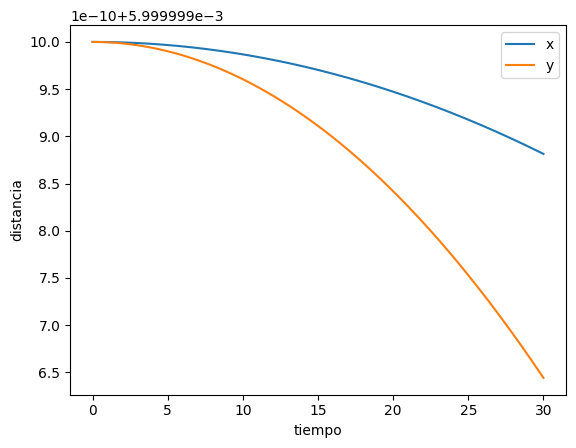

In [410]:
plt.plot(dipolo.solution_F.t, dipolo.solution_F.y[0], label="x")
plt.plot(dipolo.solution_F.t, dipolo.solution_F.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

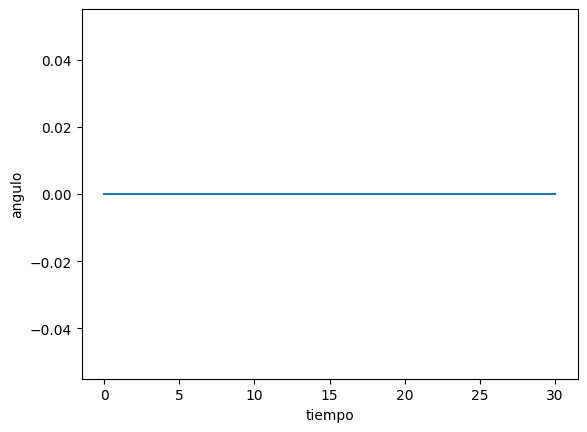

In [411]:
plt.plot(dipolo.solution_A.t, dipolo.solution_A.y[0])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [406]:
for i in dipolo.solution_F.y[1]:
    print(f"{(i-6e-3)/1e-10:.50f}")
    #print(f"{i:.50f}")

0.00000000000000000000000000000000000000000000000000
0.00000092807705964759179551037959754467010498046875
0.00000370363462121048314656945876777172088623046875
0.00000834401991944844212412135675549507141113281250
0.00001483188571960170065722195431590080261230468750
0.00002316723202167025874587125144898891448974609375
0.00003336740606041388446101336739957332611083984375
0.00004541506060107280973170418292284011840820312500
0.00005931019564364703455794369801878929138183593750
0.00007507015842289632701067603193223476409912109375
0.00009266892808668103498348500579595565795898437500
0.00011213252548714081058278679847717285156250000000
0.00013344360338951588573763729073107242584228515625
0.00015661083541118614448350854218006134033203125000
0.00018163422155215158682040055282413959503173828125
0.00020850508819503232871284126304090023040771484375
0.00023724078257458813823177479207515716552734375000
0.00026781528383867936327078496105968952178955078125
0.00030025461283944565593628794886171817779541

In [419]:
TOTAL_TIME = 30


class Example(Scene):

    def construct(self):
        
        fields = [
            CargaPuntual2D()
        ]
        
        for field in fields:
            self.add(field)
            field.set_z_index(10)
        
        def func_e_field(p):
            total_field = np.array([0., 0., 0.])
            for field in fields:
                total_field += field.campo_draw(p)
            return total_field
        
        vector_field = ArrowVectorField(func_e_field)
        vector_field._alpha = 1
        
        def show_field(mob, dt):
            # valor de alpha que quiero quitar en 3 segundos, el dt se usa para que el calculo considere fps y TOTAL_TIME
            mob._alpha = mob._alpha - (0.65*dt/3) if mob._alpha > 0.35 else 0.35
            for subm in mob.submobjects:
                subm.set_opacity(mob._alpha)
            
        vector_field.add_updater(show_field)
        self.add(vector_field)
        
        
        initial_angle = -PI # respecto al campo E

        dipolo = DipoloElectrico2D(initial_angle, pos_draw=np.array([1, 1, 0]), t_end=TOTAL_TIME,
                                   fps=self.camera.frame_rate, 
                                   fields=fields,
                                   longitud_escala=[140e-9, 420e-9])
        dipolo.save_state()
        dipolo._counter = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            #mob.rotate(mob.solution.y[0][mob._counter])
            mob.rotate(mob.solution_and_E_angle[mob._counter])
            mob.move_to([(mob.solution_F.y[0][mob._counter]-6e-3)/1e-10 + mob.pos_draw[0], 
                         (mob.solution_F.y[1][mob._counter]-6e-3)/1e-10 + mob.pos_draw[1], 
                         (mob.solution_F.y[2][mob._counter]-6e-3)/1e-10 + mob.pos_draw[2]])
            mob._counter += 1
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        
        
        self.wait(TOTAL_TIME)
        

%manim $_RV

r_pos = [-7.00000000e-08 -8.57252759e-24  0.00000000e+00]
r_neg = [7.00000000e-08 8.57252759e-24 0.00000000e+00]
l = [-1.40000000e-07 -1.71450552e-23  0.00000000e+00]
p = [-2.24000000e-26 -2.74320883e-42  0.00000000e+00]
I = 1.9600000000000001e-31
E = [1.41264221e-05 1.41264221e-05 0.00000000e+00]
tau = -5.48032164055772e-47
alpha = -2.796082469672306e-16
a_x = 2.6369321328486273e-13
------------
iterations = 902
[theta, omega] =  [-3.141592653589793, 0.0]
self.count_steps = 123
------------
E_angle = 0.7853981633974483


In [491]:
fields = [
    CargaPuntual2D()
]


dipolo = DipoloElectrico2D(-PI, pos_draw=np.array([1, 1, 0]), t_end=TOTAL_TIME,
                           fps=30, 
                           fields=fields)

r_pos = [-7.00000000e-08 -8.57252759e-24  0.00000000e+00]
r_neg = [7.00000000e-08 8.57252759e-24 0.00000000e+00]
l = [-1.40000000e-07 -1.71450552e-23  0.00000000e+00]
p = [-2.24000000e-26 -2.74320883e-42  0.00000000e+00]
I = 1.9600000000000001e-31
E = [1.41264221e-05 1.41264221e-05 0.00000000e+00]
tau = -5.48032164055772e-47
dE_r = [[-0.0011772  -0.00353161  0.        ]
 [-0.00353161 -0.0011772   0.        ]
 [ 0.          0.          0.0023544 ]]
alpha = -2.796082469672306e-16
a_x = 2.6369321328486273e-13
------------
iterations = 902
[theta, omega] =  [-3.141592653589793, 0.0]
self.count_steps = 123
------------
E_angle = 0.7853981633974483


Si hago que `p[1]` tenga el mismo valor de `p[0]` (hardcoded) entonces el movimiento en `x` y en `y` son iguales (como se ve abajo).

Mi problema es que la $p$ la calculo con respecto al campo, entonces ya no está buena para con respecto al eje coordenado en el que calculo la traslación, la $p$ deberia estar calculada respecto al eje coordenado también, de este modo, ya no tendría que sumar el ángulo del campo al los resultados de la rotación en `solution_A.y[0]`.

Arreglaré esto un siguiente notebook (_05_).

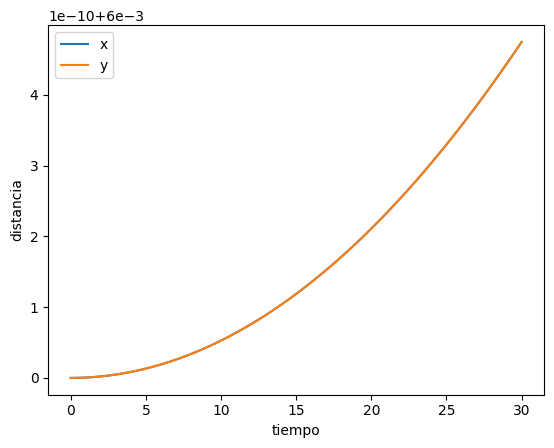

In [495]:
plt.plot(dipolo.solution_F.t, dipolo.solution_F.y[0], label="x")
plt.plot(dipolo.solution_F.t, dipolo.solution_F.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

In [486]:
for i in dipolo.solution_F.y[2]:
    print(f"{i:.50f}")

0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000000000
0.00000000000000000000000000000000000000000000

In [482]:
ele = 140e-9
theta = -PI
q1 = 1.6e-19

r_pos = np.array([(ele/2)*np.cos(theta), (ele/2)*np.sin(theta), 0])    # carga positva
r_neg = np.array([-(ele/2)*np.cos(theta), -(ele/2)*np.sin(theta), 0])  # carga negativa

r_pos = np.array([(ele/2)*np.cos(theta), 0, 0])    # carga positva
r_neg = np.array([-(ele/2)*np.cos(theta), 0, 0])  # carga negativa

l = r_pos - r_neg
p = l * q1

print("r_pos =", r_pos)
print("r_neg =", r_neg)
print("l =", l)
print("p =", p)

r_pos = [-7.e-08  0.e+00  0.e+00]
r_neg = [7.e-08 0.e+00 0.e+00]
l = [-1.4e-07  0.0e+00  0.0e+00]
p = [-2.24e-26  0.00e+00  0.00e+00]


In [470]:
np.sin(theta)

-1.2246467991473532e-16

In [472]:
np.sin(-np.pi)

-1.2246467991473532e-16

In [481]:
print(f"{np.pi:.50f}")

3.14159265358979311599796346854418516159057617187500


In [480]:
print(f"{PI:.50f}")

3.14159265358979311599796346854418516159057617187500
